# **Dataset Preparation**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!gdown https://raw.githubusercontent.com/CUTe-EmbeddedAI/DLCV_Workshop/main/220721_day7/fruit_dataset_exercise.zip 

Downloading...
From: https://raw.githubusercontent.com/CUTe-EmbeddedAI/DLCV_Workshop/main/220721_day7/fruit_dataset_exercise.zip
To: /content/fruit_dataset_exercise.zip
100% 10.6M/10.6M [00:00<00:00, 140MB/s]


In [ ]:
!unzip  fruit_dataset_exercise.zip -d /content/drive/MyDrive/fruit_dataset

In [ ]:
!rm -rf /content/fruit_dataset_exercise.zip

In [ ]:
%cd /content/drive/MyDrive/fruit_dataset

/content/drive/MyDrive/fruit_dataset


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import copy
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
import time
import numpy as np
import matplotlib.pyplot as plt

import cv2
import glob
import numpy
import random

from torch.optim import lr_scheduler
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchsummary import summary

Basic Transformation

In [ ]:
image_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [ ]:
train_directory = os.path.join('train')
test_directory = os.path.join('validation')

# Number of classes
num_classes = len(os.listdir(train_directory))
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),

    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

4


In [ ]:
data['train']

Dataset ImageFolder
    Number of datapoints: 521
    Root location: train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
data['test']

Dataset ImageFolder
    Number of datapoints: 323
    Root location: validation
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
#######################################################
#                  Create Dataloader                     #
#######################################################

# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
trainloader = DataLoader(dataset=data['train'], # use custom created train Dataset
                                     batch_size=16, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

testloader = DataLoader(dataset=data['test'], # use custom created test Dataset
                                    batch_size=4, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data

train_data_size = len(trainloader.dataset)
test_data_size = len(testloader.dataset)

print(train_data_size)
print(test_data_size)

521
323


In [ ]:
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'model_'+str(epoch)+'.pt')
            
    return model, history

# **1. Train the dataset using basic model**

In [ ]:
model_ft = models.resnet18(pretrained = True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 10.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 4)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_ft.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
num_epochs = 30
trained_model, history = train_and_validate(model_ft, criterion, optimizer_ft, num_epochs)

Epoch: 1/30
Epoch : 000, Training: Loss: 0.8997, Accuracy: 71.4012%, 
		Validation : Loss : 5.1979, Accuracy: 58.5139%, Time: 186.6684s
Epoch: 2/30
Epoch : 001, Training: Loss: 0.5675, Accuracy: 81.5739%, 
		Validation : Loss : 0.9462, Accuracy: 74.3034%, Time: 4.7545s
Epoch: 3/30
Epoch : 002, Training: Loss: 0.3980, Accuracy: 85.7965%, 
		Validation : Loss : 2.1412, Accuracy: 51.3932%, Time: 4.6637s
Epoch: 4/30
Epoch : 003, Training: Loss: 0.3343, Accuracy: 87.7159%, 
		Validation : Loss : 0.5458, Accuracy: 83.2817%, Time: 4.7537s
Epoch: 5/30
Epoch : 004, Training: Loss: 0.3026, Accuracy: 89.4434%, 
		Validation : Loss : 1.1355, Accuracy: 75.8514%, Time: 4.6331s


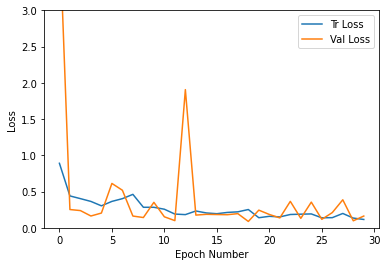

In [ ]:
# Analyze the loss curve

history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
# plt.savefig('cifar10_loss_curve.png')
plt.show()

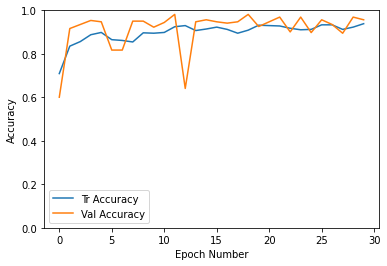

In [ ]:
# Analyze the accuracy curve

plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
# plt.savefig('cifar10_accuracy_curve.png')
plt.show()

#**2. Train on dataset using modification model**

In [ ]:
class MyCustomResnet18(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        
        resnet18 = models.resnet18(pretrained=pretrained)
        self.features = nn.ModuleList(resnet18.children())[:-1]
        self.features = nn.Sequential(*self.features)
        in_features = resnet18.fc.in_features
        self.fc0 = nn.Linear(in_features, 256)
        self.bn1 = nn.BatchNorm1d(256, eps = 1e-2)
        self.fc1 = nn.Linear(256, 64)
        self.bn2 = nn.BatchNorm1d(64, eps = 1e-2)
        self.dp = nn.Dropout (0.4)
        self.classifier = nn.Linear(64, 4)
        self.relu = nn.ReLU()
        
        # initialize all fc layers to xavier
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight, gain = 1)

    def forward(self, input_imgs):
        output = self.features(input_imgs)
        output = output.view(input_imgs.size(0), -1)
       # and also our new layers. 
        output = self.dp(self.bn1(self.relu(self.fc0(output))))
        output = self.dp(self.bn2(self.relu(self.fc1(output))))
        output = self.classifier(output)
                
        return output
    
model = MyCustomResnet18()

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

In [ ]:
num_epochs = 30
trained_model, history = train_and_validate(model, criterion, optimizer_ft, num_epochs)

In [ ]:
# Analyze the loss curve

history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
# plt.savefig('cifar10_loss_curve.png')
plt.show()

In [ ]:
# Analyze the accuracy curve

plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
# plt.savefig('cifar10_accuracy_curve.png')
plt.show()

# **3. Train dataset after model modification and data modification**

There are 4 classes of data (durian, pumpkin, tomato, and watermelon). The training data is not clean. Few classes are messed up with each other and there are only 2 training data on durian class.
Some modifications to the training dataset:
1.   Increase the durian dataset
2.   Delete mess data on other classes
3.   All data standardize to fit 200 images




Get the data from this google drive link (Add shortcut to your gdrive)
[link text](https://drive.google.com/drive/folders/1M_FX2K001rVj6xi9M72zC0wFhTDXYVK1?usp=sharing)

In [ ]:
%cd /content/drive/MyDrive/fruit_dataset_new

/content/drive/.shortcut-targets-by-id/1M_FX2K001rVj6xi9M72zC0wFhTDXYVK1/fruit_dataset_new


In [ ]:
image_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [ ]:
train_directory = os.path.join('train')
test_directory = os.path.join('validation')

# Number of classes
num_classes = len(os.listdir(train_directory))
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),

    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

4


In [ ]:
data['train']

Dataset ImageFolder
    Number of datapoints: 400
    Root location: train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
data['test']

Dataset ImageFolder
    Number of datapoints: 200
    Root location: validation
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
#######################################################
#                  Create Dataloader                     #
#######################################################

# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
trainloader = DataLoader(dataset=data['train'], # use custom created train Dataset
                                     batch_size=16, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

testloader = DataLoader(dataset=data['test'], # use custom created test Dataset
                                    batch_size=4, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data

train_data_size = len(trainloader.dataset)
test_data_size = len(testloader.dataset)

print(train_data_size)
print(test_data_size)

400
200


In [ ]:
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'model_'+str(epoch)+'.pt')
            
    return model, history

In [ ]:
class MyCustomModel(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        
        # axnet = models.alexnet(pretrained=pretrained)
        # self.features = nn.ModuleList(axnet.children())[:-1]
        # self.features = nn.Sequential(*self.features)
        # in_features = axnet.classifier[1].in_features

        resnet18 = models.resnet18(pretrained=pretrained)
        self.features = nn.ModuleList(resnet18.children())[:-1]
        self.features = nn.Sequential(*self.features)
        in_features = resnet18.fc.in_features

        self.fc0 = nn.Linear(in_features, 256)
        # self.bn1 = nn.BatchNorm1d(256, eps = 1e-2)
        # # self.fc1 = nn.Linear(256, 64)
        # # self.bn2 = nn.BatchNorm1d(64, eps = 1e-2)
        # self.dp = nn.Dropout (0.4)
        self.classifier = nn.Linear(256, 4)
        self.relu = nn.ReLU()
        
        # initialize all fc layers to xavier
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight, gain = 1)

    def forward(self, input_imgs):
        output = self.features(input_imgs)
        output = output.view(input_imgs.size(0), -1)
       # and also our new layers. 
        output = self.relu(self.fc0(output))
        # output = self.dp(self.bn2(self.relu(self.fc1(output))))
        output = self.classifier(output)
                
        return output
    
model = MyCustomModel()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model.parameters(), lr=0.000001)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

MyCustomModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [ ]:
num_epochs = 5
trained_model, history = train_and_validate(model, criterion, optimizer_ft, num_epochs)

Epoch: 1/5
Epoch : 000, Training: Loss: 0.2725, Accuracy: 94.7500%, 
		Validation : Loss : 0.4180, Accuracy: 90.0000%, Time: 5.7730s
Epoch: 2/5
Epoch : 001, Training: Loss: 0.3193, Accuracy: 91.5000%, 
		Validation : Loss : 0.3949, Accuracy: 90.5000%, Time: 5.5528s
Epoch: 3/5
Epoch : 002, Training: Loss: 0.3031, Accuracy: 92.5000%, 
		Validation : Loss : 0.4027, Accuracy: 90.5000%, Time: 5.6388s
Epoch: 4/5
Epoch : 003, Training: Loss: 0.2682, Accuracy: 95.5000%, 
		Validation : Loss : 0.3894, Accuracy: 90.0000%, Time: 6.7405s
Epoch: 5/5
Epoch : 004, Training: Loss: 0.2633, Accuracy: 94.2500%, 
		Validation : Loss : 0.3967, Accuracy: 90.0000%, Time: 5.6683s


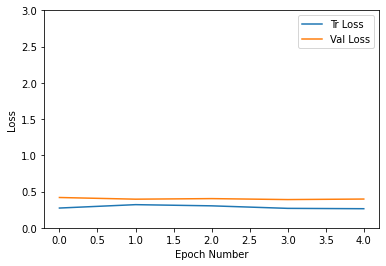

In [ ]:
# Analyze the loss curve

history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
# plt.savefig('cifar10_loss_curve.png')
plt.show()

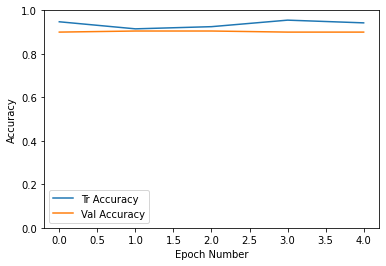

In [ ]:
# Analyze the accuracy curve

plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
# plt.savefig('cifar10_accuracy_curve.png')
plt.show()

# **4. Inference on the model with different images**


In [ ]:
!wget "https://media.istockphoto.com/photos/king-of-fruits-picture-id609794900?k=20&m=609794900&s=612x612&w=0&h=QKdTRwdUvKFHLfNYHMC6TX4InxzPTndnaIPUjPcWejc="

--2022-07-27 16:32:15--  https://media.istockphoto.com/photos/king-of-fruits-picture-id609794900?k=20&m=609794900&s=612x612&w=0&h=QKdTRwdUvKFHLfNYHMC6TX4InxzPTndnaIPUjPcWejc=
Resolving media.istockphoto.com (media.istockphoto.com)... 13.224.250.58, 13.224.250.24, 13.224.250.87, ...
Connecting to media.istockphoto.com (media.istockphoto.com)|13.224.250.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43312 (42K) [image/jpeg]
Saving to: ‘king-of-fruits-picture-id609794900?k=20&m=609794900&s=612x612&w=0&h=QKdTRwdUvKFHLfNYHMC6TX4InxzPTndnaIPUjPcWejc=.1’

king-of-fruits-pict 100%[===================>]  42.30K  --.-KB/s    in 0.002s  

2022-07-27 16:32:15 (17.2 MB/s) - ‘king-of-fruits-picture-id609794900?k=20&m=609794900&s=612x612&w=0&h=QKdTRwdUvKFHLfNYHMC6TX4InxzPTndnaIPUjPcWejc=.1’ saved [43312/43312]



In [ ]:
!wget "https://upload.wikimedia.org/wikipedia/commons/thumb/8/89/Tomato_je.jpg/220px-Tomato_je.jpg"

--2022-07-27 16:32:15--  https://upload.wikimedia.org/wikipedia/commons/thumb/8/89/Tomato_je.jpg/220px-Tomato_je.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 103.102.166.240, 2001:df2:e500:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|103.102.166.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7822 (7.6K) [image/jpeg]
Saving to: ‘220px-Tomato_je.jpg.1’

220px-Tomato_je.jpg 100%[===================>]   7.64K  --.-KB/s    in 0s      

2022-07-27 16:32:15 (843 MB/s) - ‘220px-Tomato_je.jpg.1’ saved [7822/7822]



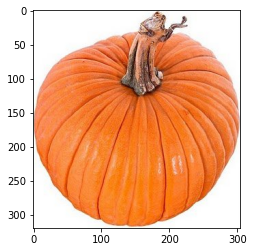

In [ ]:
img = cv2.imread("test_labu.jpg")
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_img)

In [ ]:
# Put our model in eval mode
#model = torch.load("/content/drive/MyDrive/fruit_dataset_new/model_29.pt")
trained_model.eval()

MyCustomModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [ ]:
# Carry out inference

transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
        ])

img_t = transform(img)
batch_t = torch.unsqueeze(img_t, 0).to(device)

out = trained_model(batch_t)
print(out.shape)

torch.Size([1, 4])


pumpkin 0.5175097584724426
tomato 0.20592865347862244
watermelon 0.1443290114402771
durian 0.13223253190517426


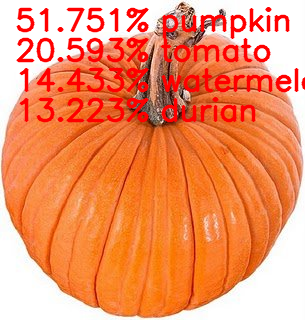

In [ ]:
from google.colab.patches import cv2_imshow

classes = ['durian', 'pumpkin', 'tomato', 'watermelon']

# Get the softmax probabilities.
probabilities = torch.nn.functional.softmax(out, dim=1)[0]
# Check the top 5 categories that are predicted.
top5_prob, top5_catid = torch.topk(probabilities, 4)

for i in range(top5_prob.size(0)):
    cv2.putText(img, f"{top5_prob[i].item()*100:.3f}%", (15, (i+1)*30), 
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.putText(img, f"{classes[top5_catid[i]]}", (160, (i+1)*30), 
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 2, cv2.LINE_AA)
    print(classes[top5_catid[i]], top5_prob[i].item())

cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
x_val = torch.randn(1, 3, 224, 224, requires_grad=True).to(device)
torch_out = trained_model(x_val)

In [ ]:
trained_model.eval()

MyCustomModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [ ]:

def Convert_to_ONNX():
  # Input to the model
  
  model.eval() 
  # Export the model
  torch.onnx.export(trained_model,               # model being run
                  x_val,                         # model input (or a tuple for multiple inputs)
                  "mynet2.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})
  print(" ") 
  print('Model has been converted to ONNX') 

In [ ]:
Convert_to_ONNX()

 
Model has been converted to ONNX
